# Question A1 (15 marks)

#### Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers.

* note: some cells are non-editable and cannot be filled, but leave them untouched. Fill up only cells which are provided.

In [1]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

1. Define the model class.

In [3]:
class MLP(nn.Module):

    def __init__(self, no_features, no_hidden, no_labels):
        super().__init__()
        self.mlp_stack = nn.Sequential(
            nn.Linear(no_features, 128),  # Input layer to first hidden layer
            nn.BatchNorm1d(128),
            nn.ReLU(),                   # Activation function (ReLU) for the first hidden layer
            nn.Dropout(0.2),             # Dropout with a probability of 0.2 for the first hidden layer
            nn.Linear(128, 128),         # First hidden layer to second hidden layer
            nn.ReLU(),                   # Activation function (ReLU) for the second hidden layer
            nn.Dropout(0.2),             # Dropout with a probability of 0.2 for the second hidden layer
            nn.Linear(128, 128),         # Second hidden layer to third hidden layer
            nn.ReLU(),                   # Activation function (ReLU) for the third hidden layer
            nn.Dropout(0.2),             # Dropout with a probability of 0.2 for the third hidden layer
            nn.Linear(128, no_labels),   # Third hidden layer to output layer
            nn.Sigmoid()                 # Sigmoid activation function for the output layer
        )

    def forward(self, x):
        # Forward pass through the network
        return self.mlp_stack(x)

#### Divide the dataset into a 70:30 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

1. Split the dataset and do preprocessing.

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

def preprocess(df):
    y = df['label']
    
    X = df.drop(columns=['filename', 'label'])
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Spliting the dataset into training and testing sets (70:30 ratio)
    X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)
    
    return X_train_scaled, y_train, X_test_scaled, y_test

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

df['label'].value_counts()

X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df)

#### Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.001**, and **batch size = 256**. Implement early stopping with patience of **3**.

1. Define a Pytorch Dataset and Dataloaders.  

In [5]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Function to initialize Dataloaders
def initialize_loaders(X_train_scaled, y_train, X_test_scaled, y_test, batch_size):
    train_dataset = CustomDataset(X_train_scaled, y_train)
    test_dataset = CustomDataset(X_test_scaled, y_test)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, test_dataloader

batch_size = 256
train_dataloader, test_dataloader = initialize_loaders(X_train_scaled, y_train, X_test_scaled, y_test, batch_size)


2. Next, define the model, optimizer and loss function.

In [6]:
# YOUR CODE HERE
import torch.optim as optim
model = MLP(no_features=77, no_hidden=128, no_labels=1)
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=0.001)
loss_fn = nn.BCELoss()

3. Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [7]:
from common_utils import EarlyStopper

early_stopper = EarlyStopper(patience=3, min_delta=0)

train_losses = []
test_losses = []

best_val_loss = float('inf')
counter = 0

train_accuracies = []
test_accuracies = []

for epoch in range(100):
    # Training loop
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_idx, (inputs, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        predicted_train = (outputs > 0.5).float()
        correct_train += (predicted_train == labels.view(-1, 1)).sum().item()
        total_train += labels.size(0)

    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels.view(-1, 1))
            val_loss += loss.item()

            predicted_test = (outputs > 0.5).float()
            total_test += labels.size(0)
            correct_test += (predicted_test == labels.view(-1, 1)).sum().item()

    test_accuracy = correct_test / total_test
    test_accuracies.append(test_accuracy)

    train_losses.append(train_loss / (batch_idx + 1))
    test_losses.append(val_loss / len(test_dataloader))

    print(f"Epoch [{epoch + 1}/100] - Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Test Accuracy: {test_accuracy:.4f} - Test Loss: {val_loss:.4f}")

    # Check for early stopping
    if early_stopper.early_stop(val_loss):
        print(f"Early stopping after epoch {epoch + 1}")
        break


Epoch [1/100] - Train Loss: 22.6865 - Train Accuracy: 0.5377 - Test Accuracy: 0.5710 - Test Loss: 10.2168
Epoch [2/100] - Train Loss: 22.2729 - Train Accuracy: 0.5800 - Test Accuracy: 0.6017 - Test Loss: 10.0476
Epoch [3/100] - Train Loss: 21.8566 - Train Accuracy: 0.6054 - Test Accuracy: 0.6249 - Test Loss: 9.8390
Epoch [4/100] - Train Loss: 21.3597 - Train Accuracy: 0.6248 - Test Accuracy: 0.6172 - Test Loss: 9.7632
Epoch [5/100] - Train Loss: 20.9005 - Train Accuracy: 0.6385 - Test Accuracy: 0.6592 - Test Loss: 9.4983
Epoch [6/100] - Train Loss: 20.4849 - Train Accuracy: 0.6593 - Test Accuracy: 0.6570 - Test Loss: 9.3930
Epoch [7/100] - Train Loss: 20.1208 - Train Accuracy: 0.6656 - Test Accuracy: 0.6686 - Test Loss: 9.2709
Epoch [8/100] - Train Loss: 19.6671 - Train Accuracy: 0.6782 - Test Accuracy: 0.6777 - Test Loss: 9.0550
Epoch [9/100] - Train Loss: 19.0828 - Train Accuracy: 0.6966 - Test Accuracy: 0.6777 - Test Loss: 9.0235
Epoch [10/100] - Train Loss: 18.7629 - Train Accuracy

#### Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.


In [8]:
print("Train Accuracies (first 10 epochs):", train_accuracies[:10])
print("Test Accuracies (first 10 epochs):", test_accuracies[:10])
print("Train Losses (first 10 epochs):", train_losses[:10])
print("Test Losses (first 10 epochs):", test_losses[:10])

Train Accuracies (first 10 epochs): [0.537741438559071, 0.5800450290318758, 0.6054034838250978, 0.624837066003081, 0.6384642730181301, 0.6593198246237706, 0.6656001895959237, 0.6781609195402298, 0.6966465220997748, 0.700793932930442]
Test Accuracies (first 10 epochs): [0.5710337202874516, 0.6017136539524599, 0.624930901050304, 0.617191818684356, 0.6592039800995025, 0.6569928137092316, 0.6686014372581537, 0.677722498618021, 0.677722498618021, 0.699281370923162]
Train Losses (first 10 epochs): [0.6874698129567233, 0.6749362602378383, 0.6623225988763751, 0.647262206583312, 0.6333497275005687, 0.6207539023775043, 0.6097201036684441, 0.595973840265563, 0.5782664273724412, 0.5685740095196348]
Test Losses (first 10 epochs): [0.6811181346575419, 0.669841468334198, 0.6559338092803955, 0.6508827567100525, 0.6332204739252726, 0.6262002984682719, 0.6180581649144491, 0.6036634564399719, 0.6015647570292155, 0.5785782217979432]


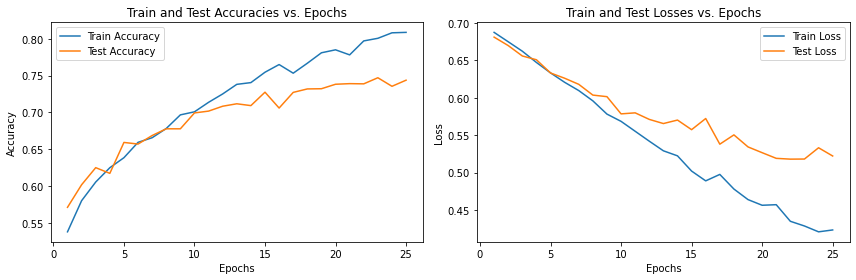

In [9]:
# YOUR CODE HERE
# Plot train and test accuracies
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Test Accuracies vs. Epochs')

# Plot train and test losses
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Test Losses vs. Epochs')

plt.tight_layout()
plt.show()

2. Comment on line plots.

answer = "Train and Test Accuracies vs. Epochs: Both training and testing accuracies show an increasing trend as the number of epochs increases, which is expected during the training of a neural network.Initially, the training accuracy is significantly lower than the testing accuracy in the first few epochs, which might indicate that the model is underfitting. As training progresses, the training accuracy catches up with the testing accuracy, and they converge to a similar value. There is no evidence of overfitting, as the testing accuracy remains relatively stable and does not decrease significantly as the training accuracy increases.

Train and Test Losses vs. Epochs:Both training and testing losses exhibit a decreasing trend as the number of epochs increases. The training loss decreases more rapidly than the testing loss initially, indicating that the model is learning from the training data. The training loss continues to decrease, while the testing loss stabilizes after a certain point, indicating that the model might have reached a point of diminishing returns, and further training may not significantly improve test performance."